In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
def f_0(x):#目标分布: \propto N(-3, 0.1)
    return np.exp(-(x+3)**2/0.1)
def f_n(x):#提议分布: \propto N(0, 1)
    return np.exp(-(x)**2/2)
def f_j(x, beta):#中间处于f_0 和 f_n间的过渡分布
    return f_0(x)**beta * f_n(x)**(1-beta)
#初始提议分布正态分布产生随机样本
p_n = st.norm(0, 1)

In [2]:
def T(x, f, n_steps=10):#Transition distribution: T(x'|x) 采用n步 Metropolis sampler

    for t in range(n_steps):
        # 在x已知下的条件分布Q(x_prime|x)随机数，N(x,1);np.random.randn()为标准正太随机数
        x_prime = x + np.random.randn()
        # 接受概率
        a = f(x_prime) / f(x)
        if np.random.rand() < a:
            x = x_prime
    return x

In [3]:
n_inter = 200  # 中间分布数
betas = np.linspace(0, 1, n_inter)
n_samples = 1000 # 采样数
samples = np.zeros(n_samples)
weights = np.zeros(n_samples)
wr=pd.DataFrame(np.zeros((n_inter-1)*n_samples).reshape(n_inter-1,n_samples))
xr=pd.DataFrame(np.zeros((n_inter-1)*n_samples).reshape(n_inter-1,n_samples))

for t in range(n_samples):
    x = p_n.rvs() # 从q(x)中初始化
    w = 1
    for n in range(1, len(betas)):  
        x = T(x, lambda x: f_j(x, betas[n]), n_steps=15) # Transition
        # 取对数计算权重函数，w *= f_{n-1}(x_{n-1}) / f_n(x_{n-1})
        w = w + np.log(f_j(x, betas[n])) - np.log(f_j(x, betas[n-1]))
        wr.iloc[n-1,t]=w
        xr.iloc[n-1,t]=x
    samples[t] = x
    weights[t] = np.exp(w)  # 指数化

In [4]:
# 均值期望
a = 1/np.sum(weights) * np.sum(weights * samples)
a

-3.007332016564891

In [5]:
#均值的方差
var_a=np.sum((samples*weights-a*weights)**2)/np.sum(weights)**2
std_a=np.sqrt(var_a)
var_a,std_a

(7.687317527005687e-05, 0.008767734899622414)

In [12]:
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签  
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

Text(0, 0.5, '权重')

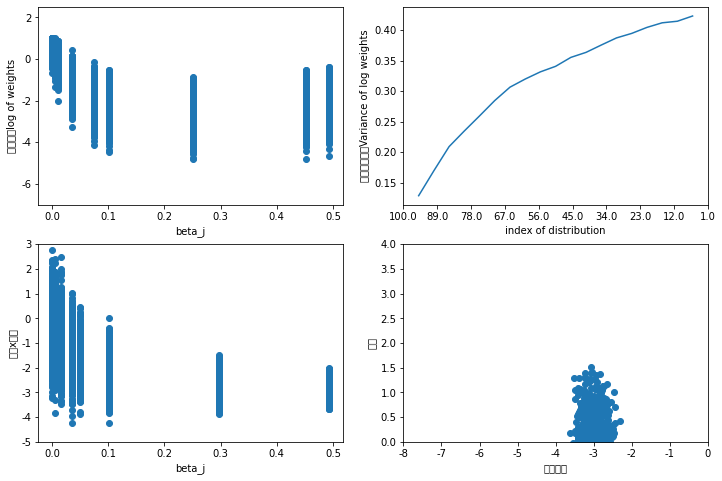

In [13]:
beta=wr.copy()
for i in range(len(betas)):
    beta.loc[i]=betas[i]

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.scatter(beta.iloc[[0,1,2,7,15,20,50,90,98]],wr.iloc[[0,1,2,7,15,20,50,90,98]])
plt.ylim(-7,2.5)
plt.xlabel("beta_j")
plt.ylabel("对数权重log of weights")

plt.subplot(2,2,3)
plt.scatter(beta.iloc[[0,1,3,7,10,20,59,98]],xr.iloc[[0,1,3,7,10,20,59,98]])
plt.ylim(-5,3)
plt.xlabel("beta_j")
plt.ylabel("样本x取值")

plt.subplot(2,2,2)
plt.plot(wr.iloc[1:20].apply('var',axis=1))
plt.xlabel("index of distribution")
plt.ylabel("对数权重方差Variance of log weights")
plt.xticks( np.linspace(0, 20,10),np.round(np.linspace(100, 1,10),1))

plt.subplot(2,2,4)
plt.scatter(samples,np.log(weights))
plt.ylim(0,4)
plt.xlim(-8,0)
plt.xlabel("样本取值")
plt.ylabel("权重")

0.04969096392178086

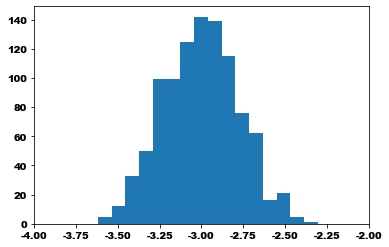

In [8]:
# 最终生成的目标分布
import matplotlib.pyplot as plt
plt.hist(samples,bins=16)
plt.xlim(-4,-2)
samples.var()

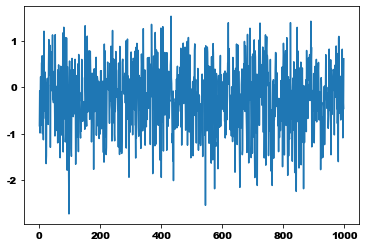

In [9]:
plt.plot(np.log(weights))#对数权重